In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from uncertainties import ufloat
import uncertainties.unumpy as unp
from uncertainties.umath import *
import uncertainties

import sys
sys.path.insert(0, '../')
from utils import dp, lp, ShorthandFormatter, red_chisquare
fmtr = ShorthandFormatter()

lp()

# Helper Functions

In [2]:
def linear(x,a,b):
    return a*x + b

def derivative(f, x, delta_x = 0.0001):
    return (f(x+delta_x)-f(x-delta_x))/(2*delta_x)

# Conversion from Vpp to mW

In [3]:
def Vpp_to_mW(Vpp, f = 80, drive = '24V', fit_err = True):
    #frequency is in MHz
    df_RF = pd.read_excel('conversion.xlsx', sheet_name = 'RF')
    df_ampli = pd.read_excel('conversion.xlsx', sheet_name = 'Amplifier')
    
    #RF power rises with vpp^2
    popt_e, cov_e = curve_fit(linear, np.log(df_RF['mVpp'][1:]), np.log(df_RF['mW'][1:]), p0 = [2,-12])

    #gain rises linearly with signal frequency
    popt_a, cov_a = curve_fit(linear, df_ampli['f in MHz'][2:4], df_ampli['gain ' + drive][2:4], p0 = [0.02, 32])
    
    if fit_err:
        #dependence of RF generator ouptput power to Vpp
        power_exp = ufloat(popt_e[0], np.sqrt(cov_e[0][0]))
        A = unp.exp(ufloat(popt_e[1], np.sqrt(cov_e[1][1])))
        
        #amplification gain of amplifier
        gain = linear(f, *popt_a)
        
        return A*Vpp**power_exp * 10**(gain/10)

    else:
        power_exp = popt_e[0]
        A = np.exp(popt_e[1])
        gain = linear(f, *popt_a)
        
        return A*Vpp**power_exp * 10**(gain/10)

In [31]:
from scipy.constants import c
lambda_0 = 632.8e-09
omega_0 = 2*np.pi*c/lambda_0

V_s = 4200

# Messung des optimalen Braggwinkels

Absatz oben rechts in Seite 2 vom Skript.

Hier für f = 80 MHz

In [32]:
a = ufloat(740, 5)
d = ufloat(9, 0.5)

theta_b = unp.arctan(d/a)/2

theta_lit = 6

print(fmtr.format('{:.1u}', theta_b*1000))
print(theta_lit)

6.1(3)
6


jetzt die Frequenzabhängigkeit, vom nächsten Absatz

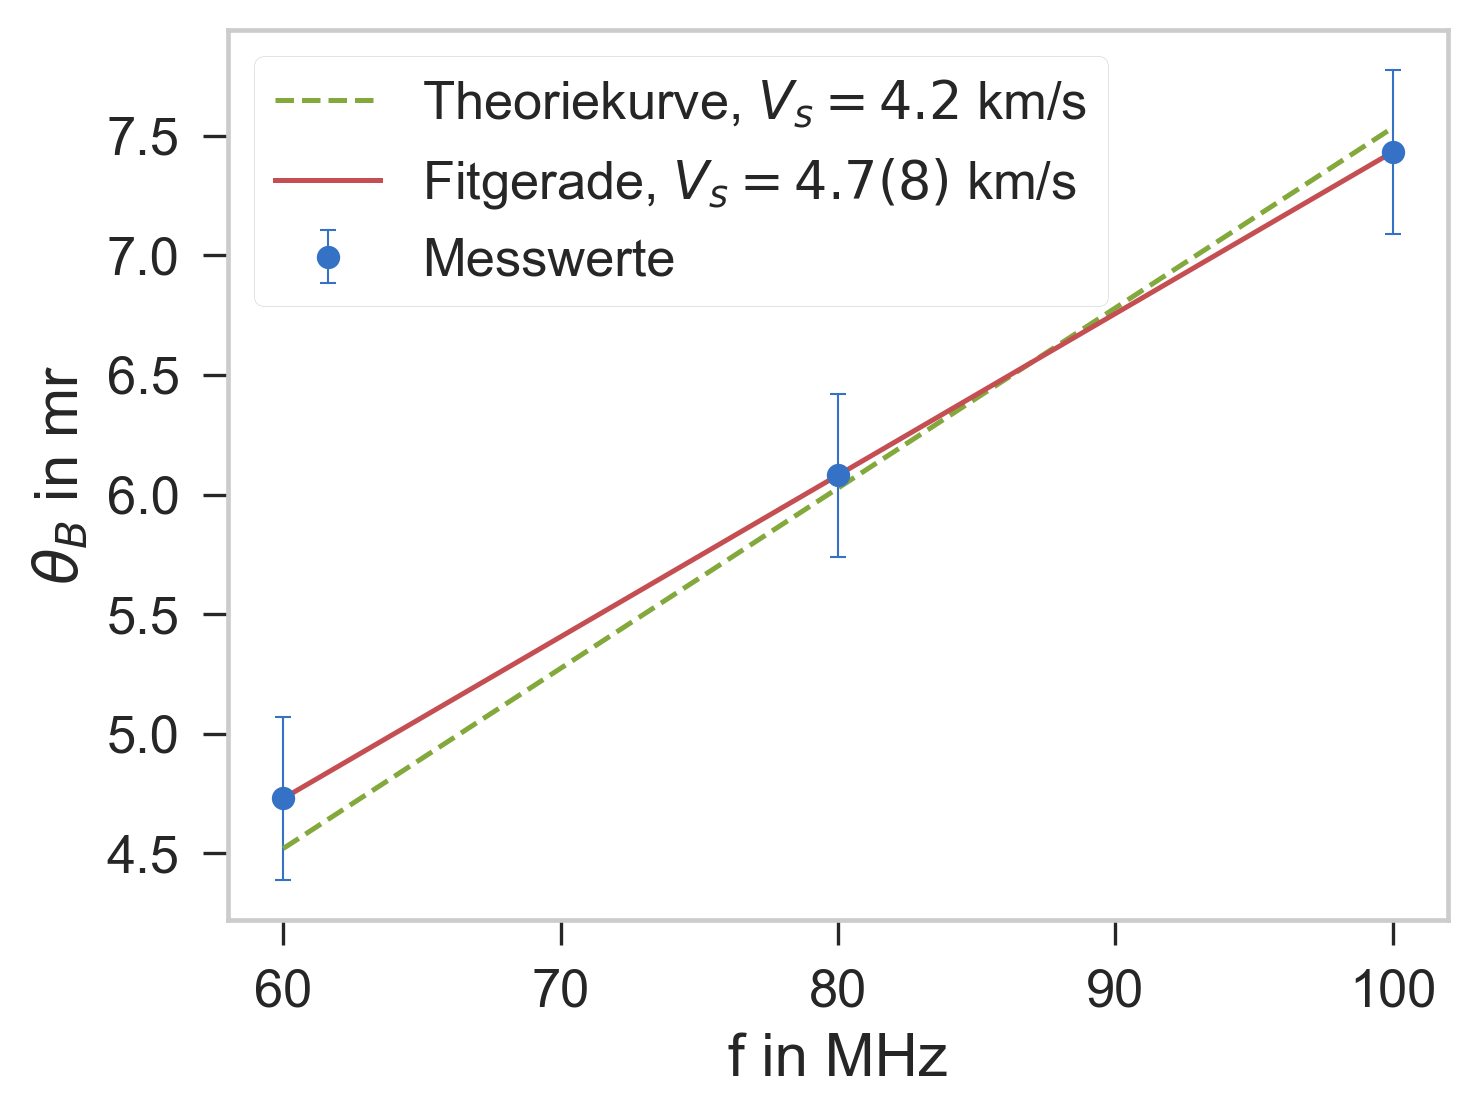

4.7(3)
6.1(3)
7.4(3)


In [34]:
lp()

a = ufloat(740, 5)
d = unp.uarray([7,9,11],[0.5,0.5,0.5])
rf = np.array([60,80,100])

theta_b = 1000*unp.arctan(d/a)/2

popt, cov = curve_fit(linear, unp.nominal_values(rf), unp.nominal_values(theta_b), sigma = unp.std_devs(theta_b), absolute_sigma = True)
V_s_fit = 0.5*lambda_0/ufloat(popt[0], np.sqrt(cov[0][0]))*1e06

x = np.linspace(60,100,501)

plt.errorbar(rf, unp.nominal_values(theta_b), yerr = unp.std_devs(theta_b), fmt = 'bo', capsize= 2, linewidth = 0.5, capthick = 0.5, label = 'Messwerte')
plt.plot(x, 0.5*lambda_0*x/V_s*1e09, 'g--', label = 'Theoriekurve, $V_s = 4.2$ km/s')
plt.plot(x, linear(x, *popt), 'r-', label = fmtr.format(r'Fitgerade, $V_s = {}$ km/s', V_s_fit))

plt.xlabel('f in MHz')
plt.ylabel(r'$\theta_B$ in mr')

plt.legend()

plt.tight_layout(pad = 0.2)
plt.savefig('Plots/braggwinkel')

plt.show()
for t in theta_b:
    print(fmtr.format('{:.1u}', t))

# Intenstätsabhängigkeit und Sättigungsleistung

## Insertion loss

Power measured with Thorlabs optical power meter head S120C.

Datasheet: https://www.thorlabs.com/drawings/ede390f4bb4da1eb-5D1F6950-05A9-3F54-614290C10D33C304/S120C-SpecSheet.pdf

https://www.thorlabs.com/thorproduct.cfm?partnumber=S120C

From datasheet: Uncertainty in the 440-920 nm range is 3%

In [134]:
#p_in = ufloat(970, 0.03*970)
#p_out = ufloat(930, 0.03*930)
r = 0.99
corr_matrix = [[1,r],[r,1]]
(p_in, p_out) = uncertainties.correlated_values_norm([(970,0.03*970), (930,0.03*930)], corr_matrix)

il = 1-p_out/p_in

print(fmtr.format('Insertion Loss in percent: IL = {:.1u}%', il*100))

Insertion Loss in percent: IL = 4.1(4)%


In [41]:
p_out/p_in

0.9587628865979382+/-0.04067686431980345

## Intensitätsabhängigkeit

In [37]:
#Daten nehmen
vpp_rf = np.array([0, 100, 200, 250, 300, 350, 400, 450, 500, 550, 600])
p_rf = Vpp_to_mW(vpp_rf, f = 80, drive = '24V', fit_err = False)
p_rf_err = unp.std_devs(Vpp_to_mW(vpp_rf, f = 80, drive = '24V', fit_err = True))

p_1 = np.array([0, 113, 361, 504, 640, 756, 840, 890, 900, 880, 825])
p_1_err = 0.03*p_1

epsilon = p_1/p_out
for i in range(len(p_rf)):
    print('Skalierungsfehler auf x Achse = {:.1f}%'.format(p_rf_err[i]/p_rf[i]*100))

Skalierungsfehler auf x Achse = nan%
Skalierungsfehler auf x Achse = 0.7%
Skalierungsfehler auf x Achse = 0.8%
Skalierungsfehler auf x Achse = 0.8%
Skalierungsfehler auf x Achse = 0.8%
Skalierungsfehler auf x Achse = 0.8%
Skalierungsfehler auf x Achse = 0.8%
Skalierungsfehler auf x Achse = 0.8%
Skalierungsfehler auf x Achse = 0.8%
Skalierungsfehler auf x Achse = 0.8%
Skalierungsfehler auf x Achse = 0.9%


c:\users\calva\appdata\local\programs\python\python37-32\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\calva\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


### Mit Epsilon direkt

c:\users\calva\appdata\local\programs\python\python37-32\lib\site-packages\scipy\optimize\minpack.py:721: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
..\utils.py:45: RuntimeWarning: divide by zero encountered in true_divide
  return sum(((np.array(obs)-np.array(expected))/np.array(alpha))**2)


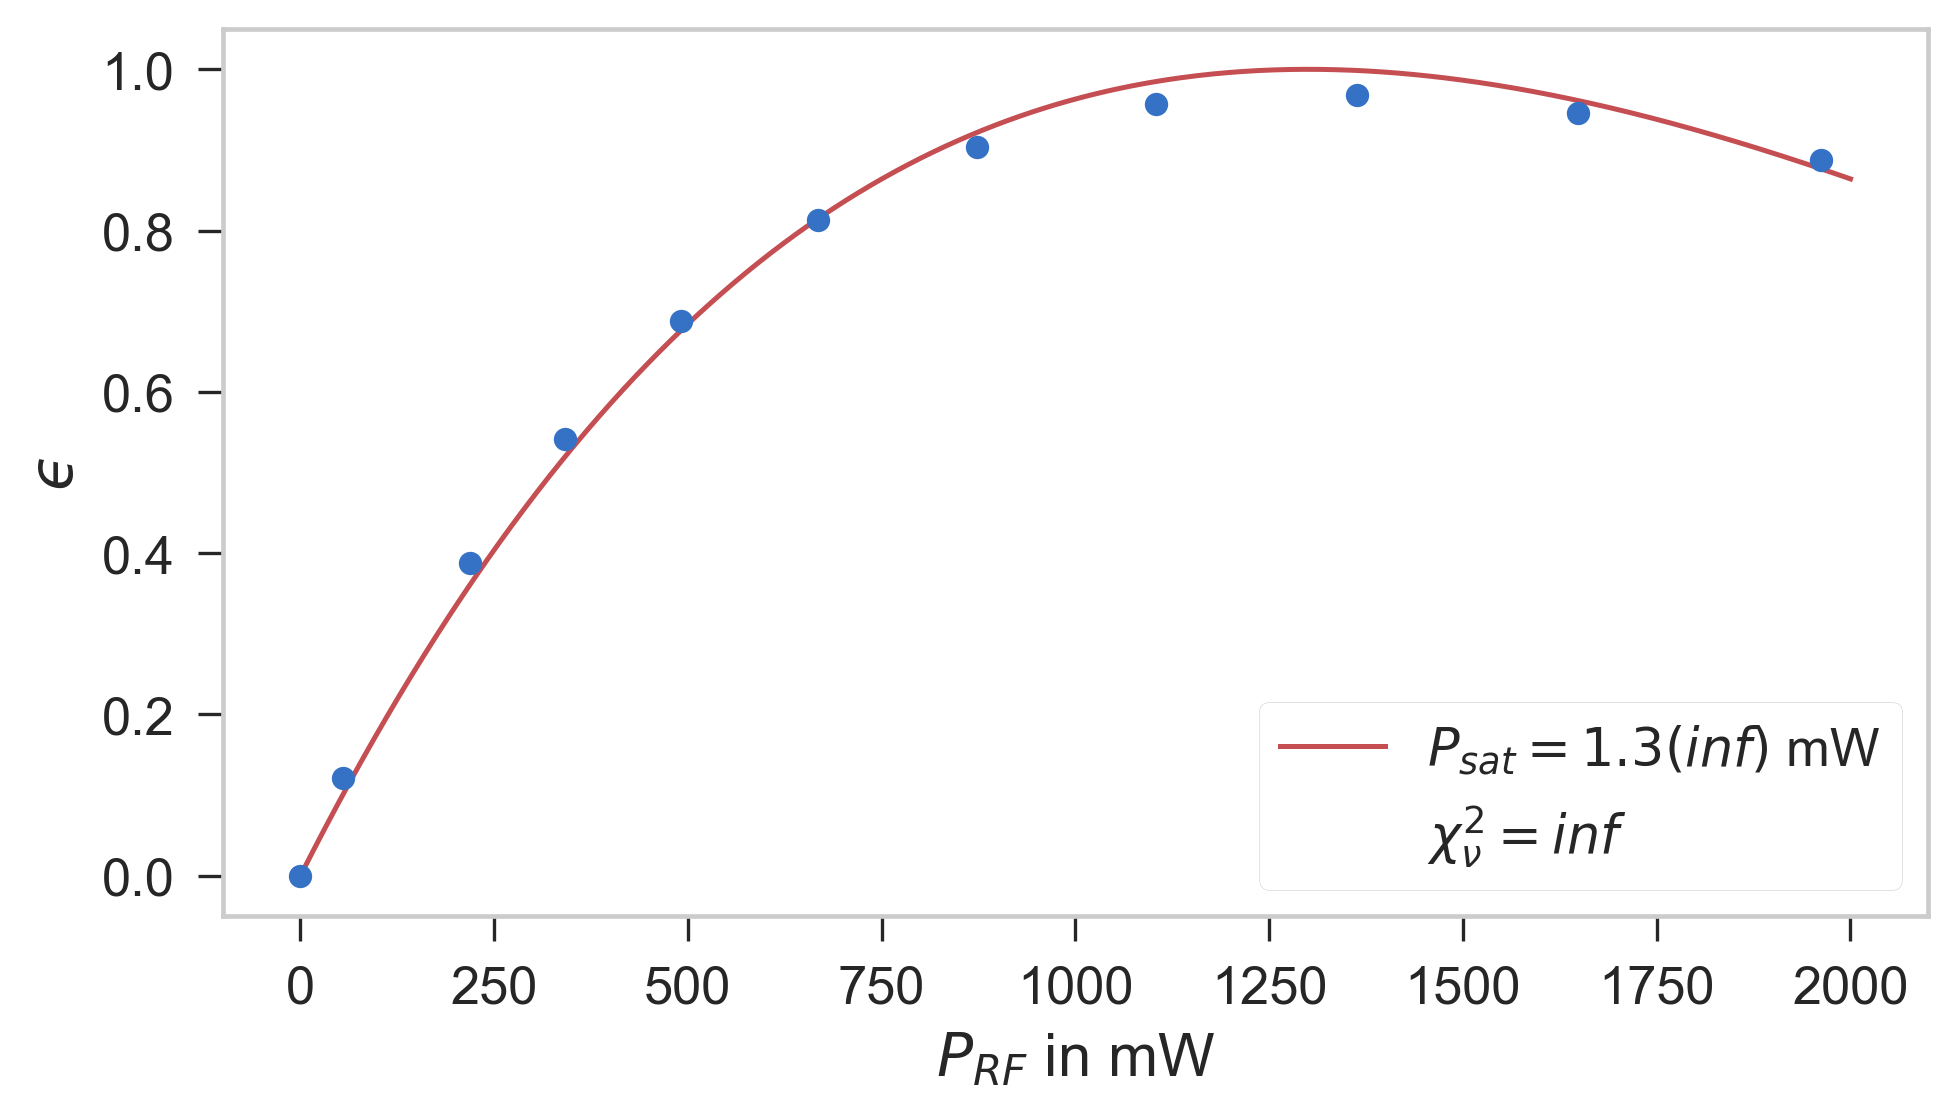

In [38]:
lp(aspect = 16/9)

def epsilon_power(p_rf, p_sat):
    return np.sin(0.5*np.pi*np.sqrt(p_rf/p_sat))**2

popt, cov = curve_fit(epsilon_power, p_rf[1:], unp.nominal_values(epsilon[1:]), sigma = unp.std_devs(epsilon[1:]), absolute_sigma = True, p0 = [1300])
p_sat = ufloat(popt[0], np.sqrt(cov[0][0]))
#epsilon_background = ufloat(popt[1], np.sqrt(cov[1][1]))

chi2 = red_chisquare(unp.nominal_values(epsilon[1:]), epsilon_power(p_rf[1:], *popt), alpha = unp.std_devs(epsilon[1:]), ddof = len(epsilon)-2)

x = np.linspace(0,2000, 501)
plt.errorbar(p_rf, unp.nominal_values(epsilon), yerr = unp.std_devs(epsilon), fmt = 'bo', capsize = 2, linewidth = 0.5, capthick = 0.5)
plt.plot(x, epsilon_power(x, *popt), 'r-', label = fmtr.format(r'$P_{{sat}} = {:.1u}$ mW', p_sat/1000))
#plt.plot([],[], ' ', label = fmtr.format(r'$P_{{B}} = {:.1u}$ $\mu$W', epsilon_background))
plt.plot([],[], ' ', label = r'$\chi^2_\nu = {:.1f}$'.format(chi2))

plt.xlabel(r'$P_{RF}$ in mW')
plt.ylabel(r'$ϵ$')

plt.legend()

plt.tight_layout(pad = 0.2)
#plt.savefig('Plots/epsilon_power')

plt.show()

### Mit P_1 dann transformiert

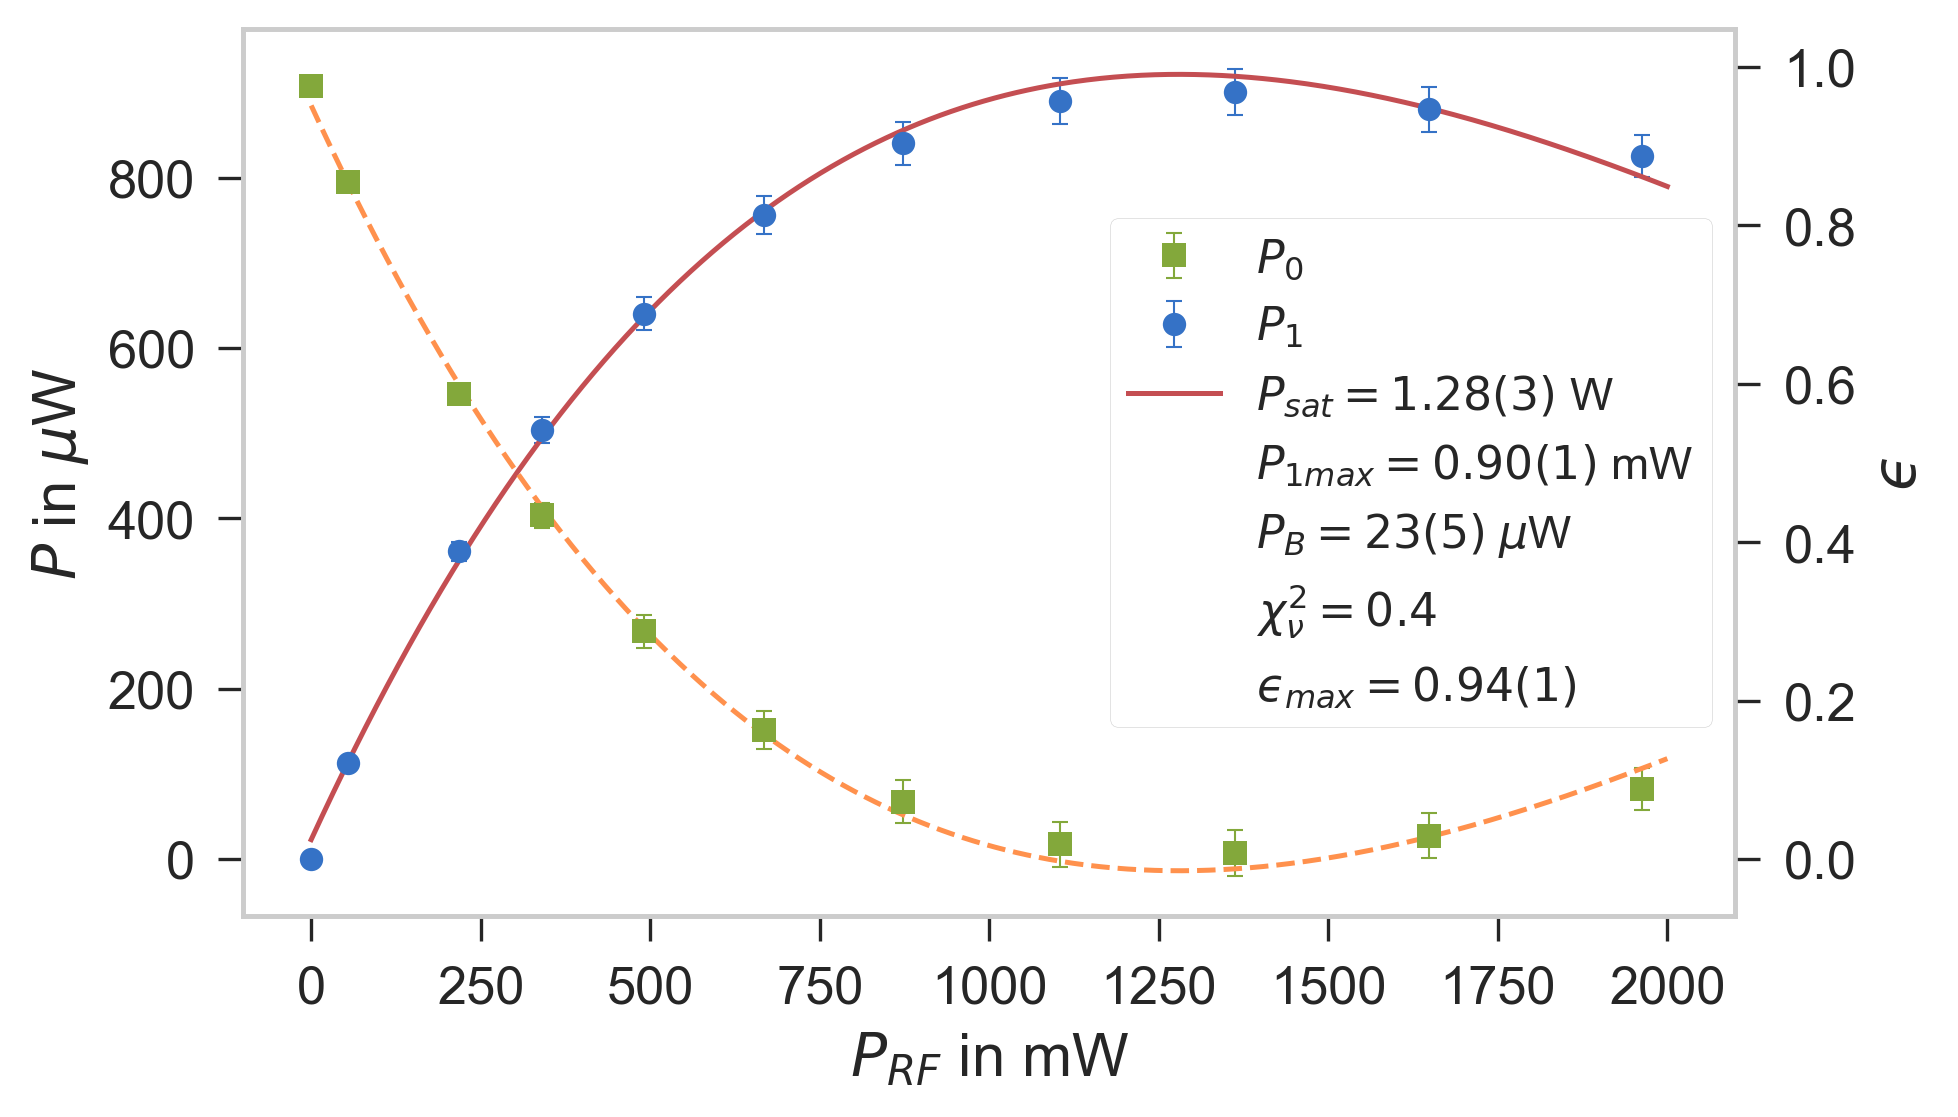

In [39]:
lp(aspect = 16/9)
plt.rcParams.update({'figure.subplot.right': 0.85})

def power(p_rf, p_sat, p_1, offset):
    return p_1*epsilon_power(p_rf, p_sat) + offset

popt, cov = curve_fit(power, p_rf[1:], p_1[1:], sigma = p_1_err[1:], absolute_sigma = True, p0 = [1300, 930,10])
p_sat = ufloat(popt[0], np.sqrt(cov[0][0]))
p_1_max = ufloat(popt[1], np.sqrt(cov[1][1]))
p_background = ufloat(popt[2], np.sqrt(cov[2][2]))

#p_out = p_1_max.nominal_value
p_out = 930

def power_fit(p_rf):
    return power(p_rf, *popt)

p_1_err_2 = p_rf_err*derivative(power_fit, p_rf)
p_1_err_combi = np.sqrt(p_1_err**2 + p_1_err_2**2)

chi2 = red_chisquare(p_1[1:], power(p_rf[1:], *popt), alpha = p_1_err_combi[1:], ddof = len(epsilon)-2)

fig, ax = plt.subplots()

x = np.linspace(0,2000, 501)
ax.errorbar(p_rf, p_1, yerr = p_1_err, fmt = 'bo', capsize = 2, linewidth = 0.5, capthick = 0.5, label = r'$P_1$')
ax.plot(x, power(x, *popt), 'r-', label = fmtr.format(r'$P_{{sat}} = {:.1u}$ W', p_sat/1000))
ax.plot([],[], ' ', label = fmtr.format(r'$P_{{1 max}} = {:.1u}$ mW', p_1_max/1000))
ax.plot([],[], ' ', label = fmtr.format(r'$P_{{B}} = {:.1u}$ $\mu$W', p_background))
ax.plot([],[], ' ', label = r'$\chi^2_\nu = {:.1f}$'.format(chi2))
ax.plot([],[], ' ', label = fmtr.format(r'$ϵ_{{max}} = {:.1u}$', (p_1_max-p_background)/p_out))

ax.errorbar(p_rf, p_out-p_1-popt[2], yerr = p_1_err, fmt = 'gs', capsize = 2, linewidth = 0.5, capthick = 0.5, label = r'$P_0$')
ax.plot(x, p_out-power(x, *popt)-popt[2], 'y--')

ax2 = ax.twinx()
ax2.set_ylim((l/p_out for l in ax.get_ylim()))

ax.set_xlabel(r'$P_{RF}$ in mW')
ax.set_ylabel(r'$P$ in $\mu$W')
ax2.set_ylabel(r'$ϵ$')

h, l = ax.get_legend_handles_labels()
ax.legend(handles = [h[i] for i in [6,5,0,1,2,3,4]], fontsize = 'small')

plt.tight_layout(pad = 0.2)
plt.savefig('Plots/epsilon_power')

plt.show()
plt.close()

# Frequenzabhängigkeit und Qualitätsfaktor

In [18]:
f = np.arange(60,102,2)

p_1 = np.array([84,90,94,99,102,105,107,112,113,113,112,112,112,111,110,109,106,102,96,90,81])
p_1_err = 0.03*p_1

df = pd.DataFrame({'frequency': f, 'output power': p_1, 'output error': p_1_err})

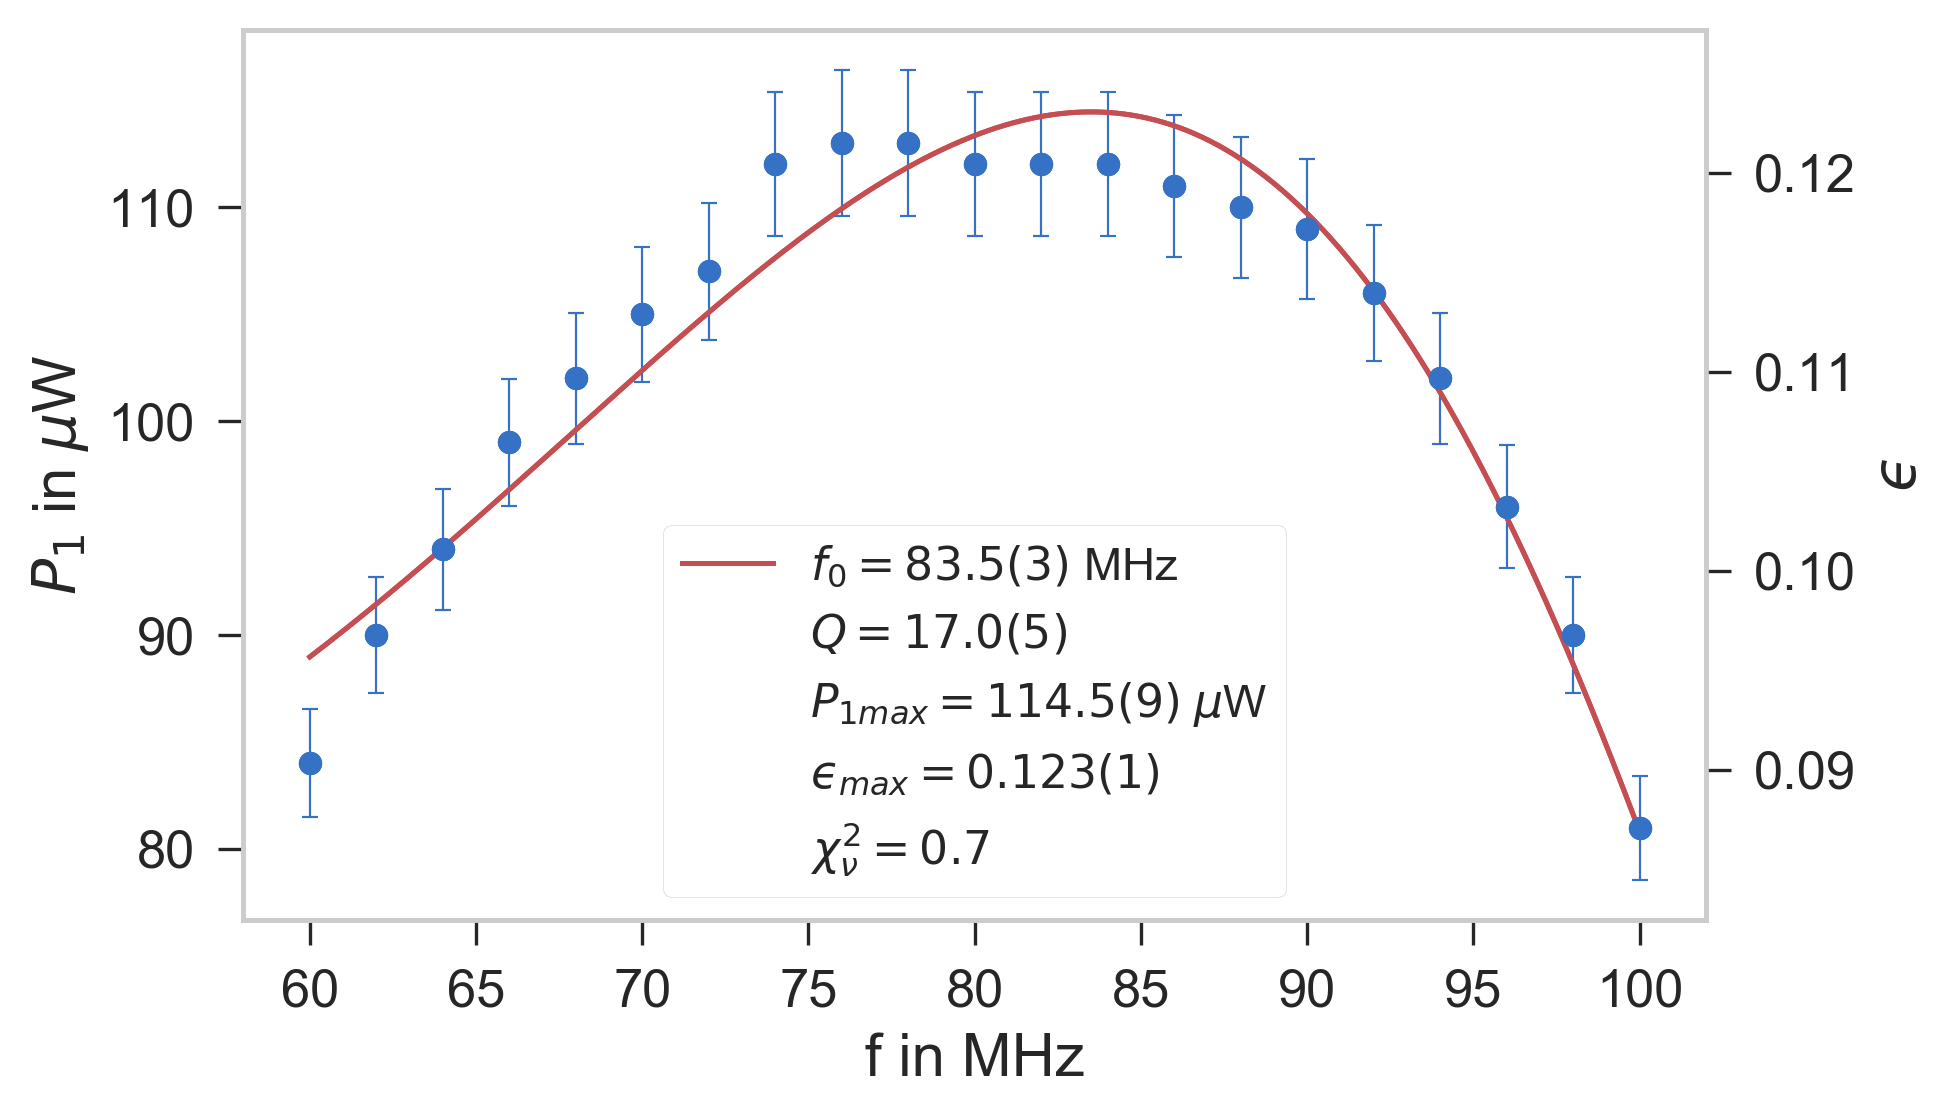

In [20]:
lp(aspect = 16/9)
plt.rcParams.update({'figure.subplot.right': 0.85})

def epsilon_frequency(f, Q, A, f0):
    F = f/f0
    arg = Q*F*(1-F)/4
    return A*(np.sin(arg)/arg)**2
p_out = 930

popt, cov = curve_fit(epsilon_frequency, f, p_1, sigma = p_1_err, p0 = [11,114,83])

chi2 = red_chisquare(p_1, epsilon_frequency(f, *popt), alpha = p_1_err, ddof = len(p_1)-3)

f_0 = ufloat(popt[2], np.sqrt(cov[2][2]))
Q_freq = ufloat(popt[0], np.sqrt(cov[0][0]))
p_1_max = ufloat(popt[1], np.sqrt(cov[1][1]))

x = np.linspace(60, 100, 501)

fig, ax = plt.subplots()

ax.errorbar(f, p_1, yerr = p_1_err, fmt = 'bo', capsize = 2, linewidth = 0.5, capthick = 0.5)
ax.plot(x, epsilon_frequency(x, *popt), 'r-', label = fmtr.format(r'$f_0 = {:.1u}$ MHz', f_0))
ax.plot([],[], ' ', label = fmtr.format(r'$Q = {:.1u}$', Q_freq))
ax.plot([],[], ' ', label = fmtr.format(r'$P_{{1max}} = {:.1u}$ $\mu$W', p_1_max))
ax.plot([],[], ' ', label = fmtr.format(r'$ϵ_{{max}} = {:.1u}$', p_1_max/p_out))
ax.plot([],[], ' ', label = r'$\chi^2_\nu = {:.1f}$'.format(chi2))

ax2 = ax.twinx()
ax2.errorbar(f, p_1/p_out, yerr = p_1_err/p_out, fmt = 'bo', capsize = 2, linewidth = 0.5, capthick = 0.5)
ax2.plot(x, epsilon_frequency(x, *popt)/p_out, 'r-', label = fmtr.format(r'$ϵ_{{max}} = {:.1u}$ $\mu$W', p_1_max/p_out))

ax.set_xlabel('f in MHz')
ax.set_ylabel('$P_1$ in $\mu$W')

ax2.set_ylabel('$ϵ$')

ax.legend(fontsize = 'small')

plt.tight_layout(pad = 0.2)
plt.savefig('Plots/epsilon_frequency')

plt.show()
plt.close()

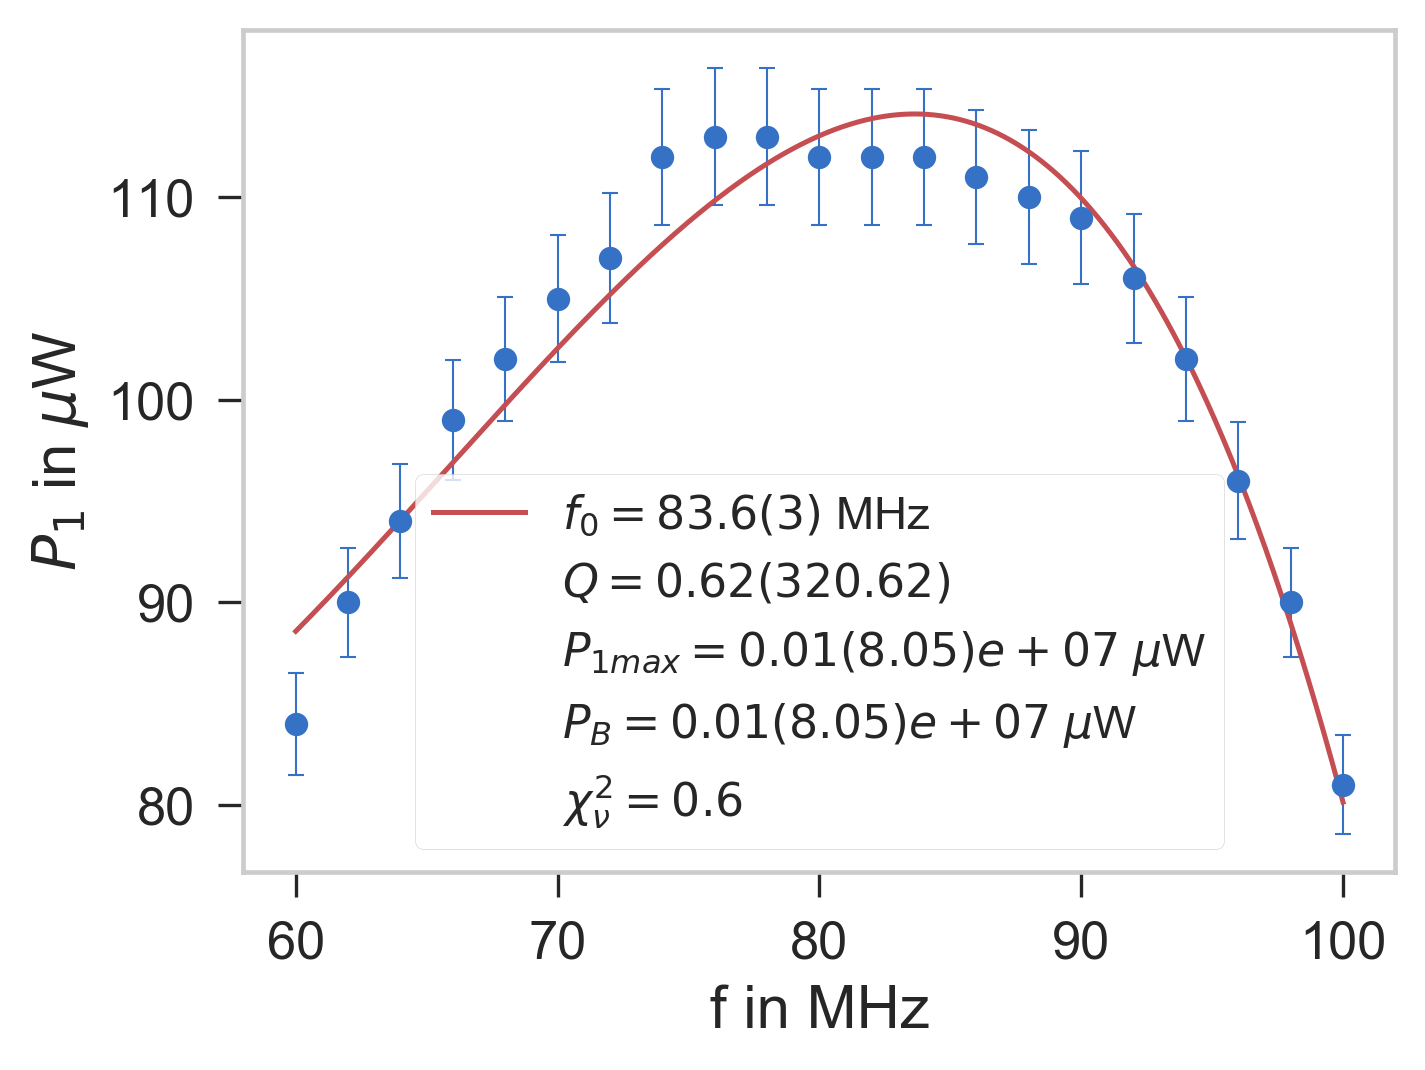

In [210]:
lp()
def epsilon_frequency(f, Q, A, f0, offset):
    F = f/f0
    arg = Q*F*(1-F)/4
    return A*(np.sin(arg)/arg)**2 + offset

popt, cov = curve_fit(epsilon_frequency, f, p_1, sigma = p_1_err, p0 = [17,114,83,-10], maxfev = 10000)

chi2 = red_chisquare(p_1, epsilon_frequency(f, *popt), alpha = p_1_err, ddof = len(p_1)-len(popt))

f_0 = ufloat(popt[2], np.sqrt(cov[2][2]))
#f_0 = ufloat(80,0)
Q_freq = ufloat(popt[0], np.sqrt(cov[0][0]))
p_1_max = ufloat(popt[1], np.sqrt(cov[1][1]))
p_background = ufloat(popt[1], np.sqrt(cov[1][1]))

x = np.linspace(60, 100, 501)

plt.errorbar(f, p_1, yerr = p_1_err, fmt = 'bo', capsize = 2, linewidth = 0.5, capthick = 0.5)
plt.plot(x, epsilon_frequency(x, *popt), 'r-', label = fmtr.format(r'$f_0 = {:.1u}$ MHz', f_0))
plt.plot([],[], ' ', label = fmtr.format(r'$Q = {:.5u}$', Q_freq))
plt.plot([],[], ' ', label = fmtr.format(r'$P_{{1max}} = {:.3u}$ $\mu$W', p_1_max))
plt.plot([],[], ' ', label = fmtr.format(r'$P_B = {:.3u}$ $\mu$W', p_background))
plt.plot([],[], ' ', label = r'$\chi^2_\nu = {:.1f}$'.format(chi2))

plt.xlabel('f in MHz')
plt.ylabel('$P_1$ in $\mu$W')
#plt.ylabel('$ϵ$')

plt.legend(fontsize = 'small')

plt.tight_layout(pad = 0.2)
plt.savefig('Plots/epsilon_frequency_offset')

plt.show()

# Winkelabhängigkeit

In [26]:
theta_b = 6.1*180/np.pi/1000
theta_b_err = 0.3*180/np.pi/1000
delta = np.arange(-0.6, 0.64, 0.04)
delta_err = 0.02

Delta = delta/theta_b
Delta_err = delta_err/theta_b
Delta_err_sys = theta_b_err/theta_b

p_1 = np.array([29,32,21,24,17,12,16,36,71,130,200,271,331,373,380,380,363,320,254,184,123,71,32,15,12,18,26,32,32,29,23])
p_1_err = 0.03*p_1

df = pd.DataFrame({'delta': delta, 'delta err': delta_err, 'Delta': Delta, 'Delta err': Delta_err, 'output power': p_1, 'output error': p_1_err})

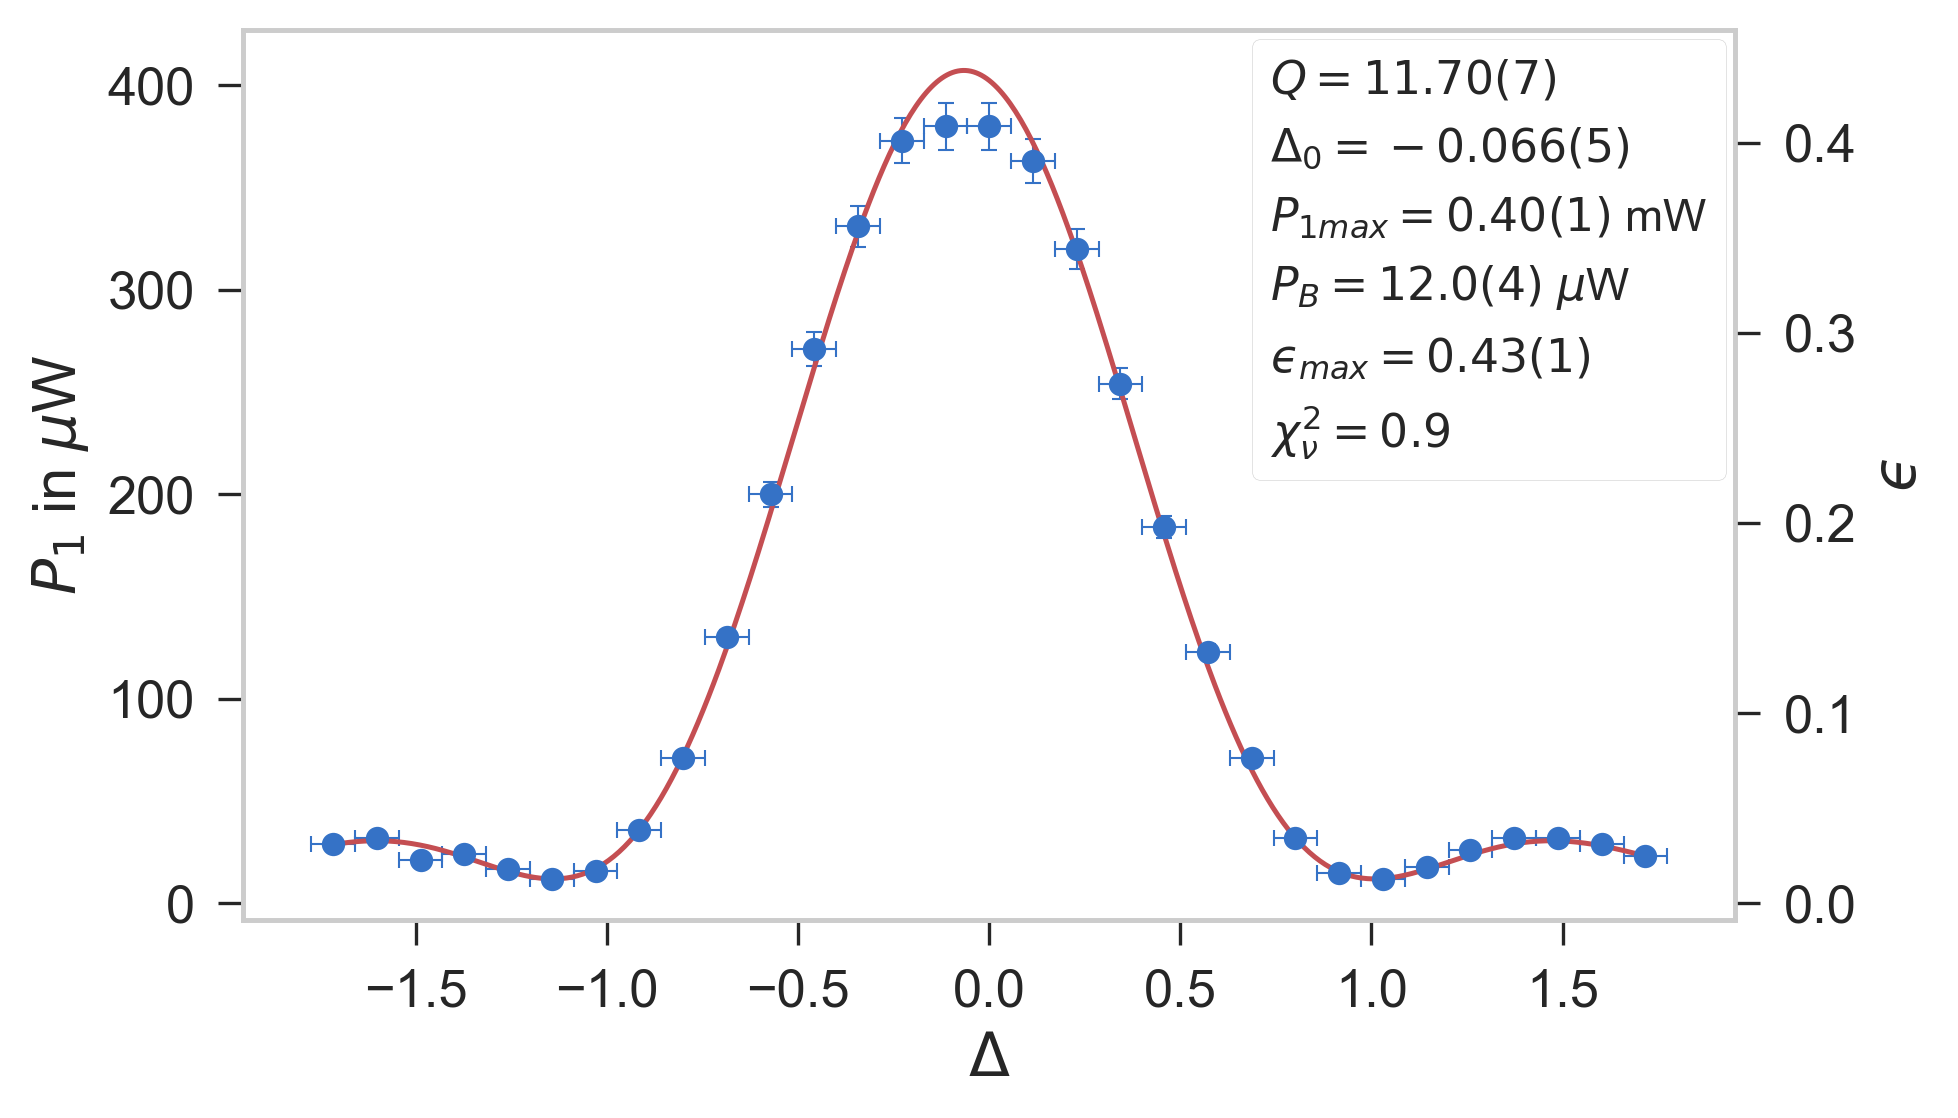

In [28]:
lp(aspect = 16/9)
plt.rcParams.update({'figure.subplot.right': 0.85})

def epsilon_delta(Delta, Q, A, Delta_0, offset):
    arg = Q*(Delta-Delta_0)/4
    return A*(np.sin(arg)/arg)**2 + offset

popt, cov = curve_fit(epsilon_delta, Delta, p_1, sigma = p_1_err, p0 = [10,400,-0.1, 10])

def epsilon_delta_fit(Delta):
    return epsilon_delta(Delta, *popt)

p_1_err_2 = Delta_err*derivative(epsilon_delta_fit, Delta)
p_1_err_combi = np.sqrt(p_1_err**2 + p_1_err_2**2)

chi2 = red_chisquare(p_1, epsilon_delta(Delta, *popt), alpha = p_1_err_combi, ddof = len(p_1)-3)

Q_delta = ufloat(popt[0], np.sqrt(cov[0][0]))
p_1_max = ufloat(popt[1], np.sqrt(cov[1][1]))
Delta_0 = ufloat(popt[2], np.sqrt(cov[2][2]))
p_background = ufloat(popt[3], np.sqrt(cov[3][3]))

x = np.linspace(min(Delta), max(Delta), 501)

fig, ax = plt.subplots()

ax.errorbar(Delta, p_1, xerr = Delta_err, yerr = p_1_err, fmt = 'bo', capsize = 2, linewidth = 0.5, capthick = 0.5)
ax.plot(x, epsilon_delta(x, *popt), 'r-')

ax.plot([],[], ' ', label = fmtr.format(r'$Q = {:.1u}$', Q_delta))
ax.plot([],[], ' ', label = fmtr.format(r'$\Delta_0 = {:.1u}$', Delta_0))
ax.plot([],[], ' ', label = fmtr.format(r'$P_{{1max}} = {:.1u}$ mW', p_1_max/1000))
ax.plot([],[], ' ', label = fmtr.format(r'$P_{{B}} = {:.1u}$ $\mu$W', p_background))
ax.plot([],[], ' ', label = fmtr.format(r'$ϵ_{{max}} = {:.1u}$', p_1_max/p_out))
ax.plot([],[], ' ', label = r'$\chi^2_\nu = {:.1f}$'.format(chi2))

ax2 = ax.twinx()
ax2.set_ylim((l/p_out for l in ax.get_ylim()))

ax.set_xlabel('$\Delta$')
ax.set_ylabel('$P_1$ in $\mu$W')
ax2.set_ylabel('$ϵ$')

ax.legend(fontsize = 'small', loc = 'upper right', handlelength = 0, handletextpad = 0, borderaxespad = 0.2)

plt.tight_layout(pad = 0.2)
plt.savefig('Plots/epsilon_delta')
plt.show()
plt.close()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

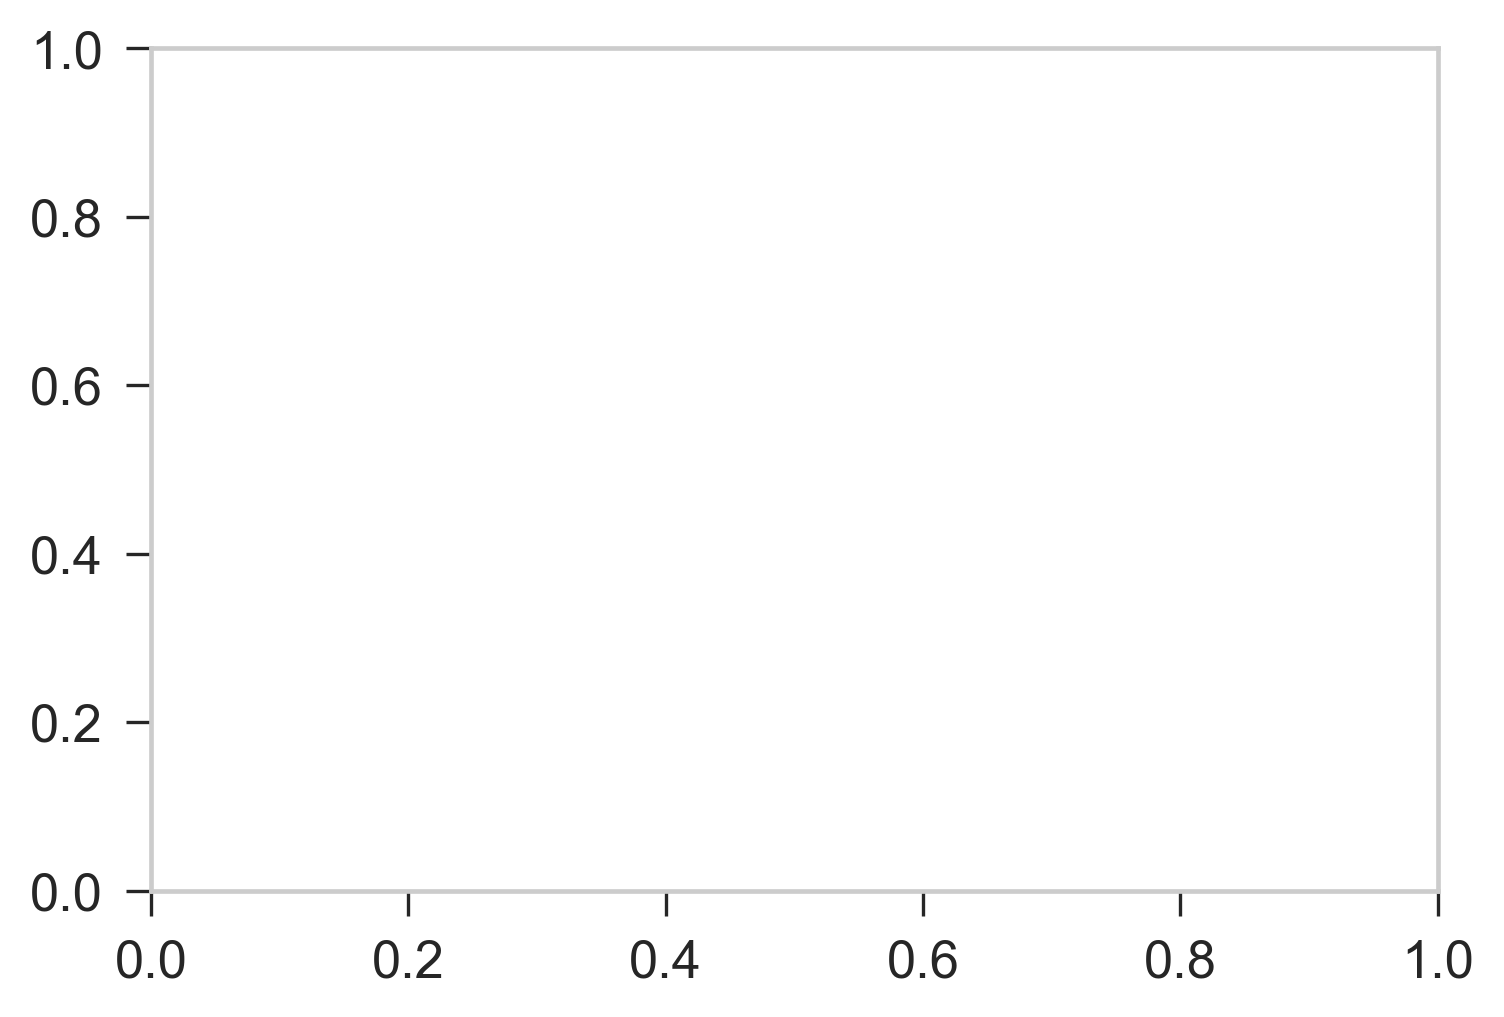

In [25]:
fig, ax = plt.subplots()

ax.errorbar(Delta, p_1, yerr = p_1_err_combi, fmt = 'bo', capsize = 2, linewidth = 0.5, capthick = 0.5)
ax.plot(x, epsilon_delta(x, *popt), 'r-', label = fmtr.format(r'$Q = {:.1u}$', Q_delta))

ax.plot([],[], ' ', label = fmtr.format(r'$\Delta_0 = {:.1u}$', Delta_0))
ax.plot([],[], ' ', label = fmtr.format(r'$P_{{1max}} = {:.1u}$ mW', p_1_max/1000))
ax.plot([],[], ' ', label = fmtr.format(r'$P_{{B}} = {:.1u}$ $\mu$W', p_background))
ax.plot([],[], ' ', label = fmtr.format(r'$ϵ_{{max}} = {:.1u}$', p_1_max/p_out))
ax.plot([],[], ' ', label = r'$\chi^2_\nu = {:.1f}$'.format(chi2))

ax2 = ax.twinx()
ax2.set_ylim((l/p_out for l in ax.get_ylim()))


ax.set_xlabel('$\Delta$')
ax.set_ylabel('$P_1$ in $\mu$W')
ax2.set_ylabel('$ϵ$')

ax.legend(fontsize = 'small', loc = 'upper right', handlelength = 0, handletextpad = 0, borderaxespad = 0.2)

plt.tight_layout(pad = 0.2)
plt.savefig('Plots/epsilon_delta_yerr')

plt.show()
plt.close()

In [126]:
print('systematischer Skalierungsfehler auf der x-Achse = {:.2f}%'.format(100*Delta_err_sys))

systematischer Skalierungsfehler auf der x-Achse = 4.92%


In [127]:
print(fmtr.format(r'Q = {:.1u}', ufloat(Q_delta.nominal_value, np.sqrt(Q_delta.std_dev**2 + Q_delta.nominal_value*Delta_err_sys**2))))

Q = 11.7(2)


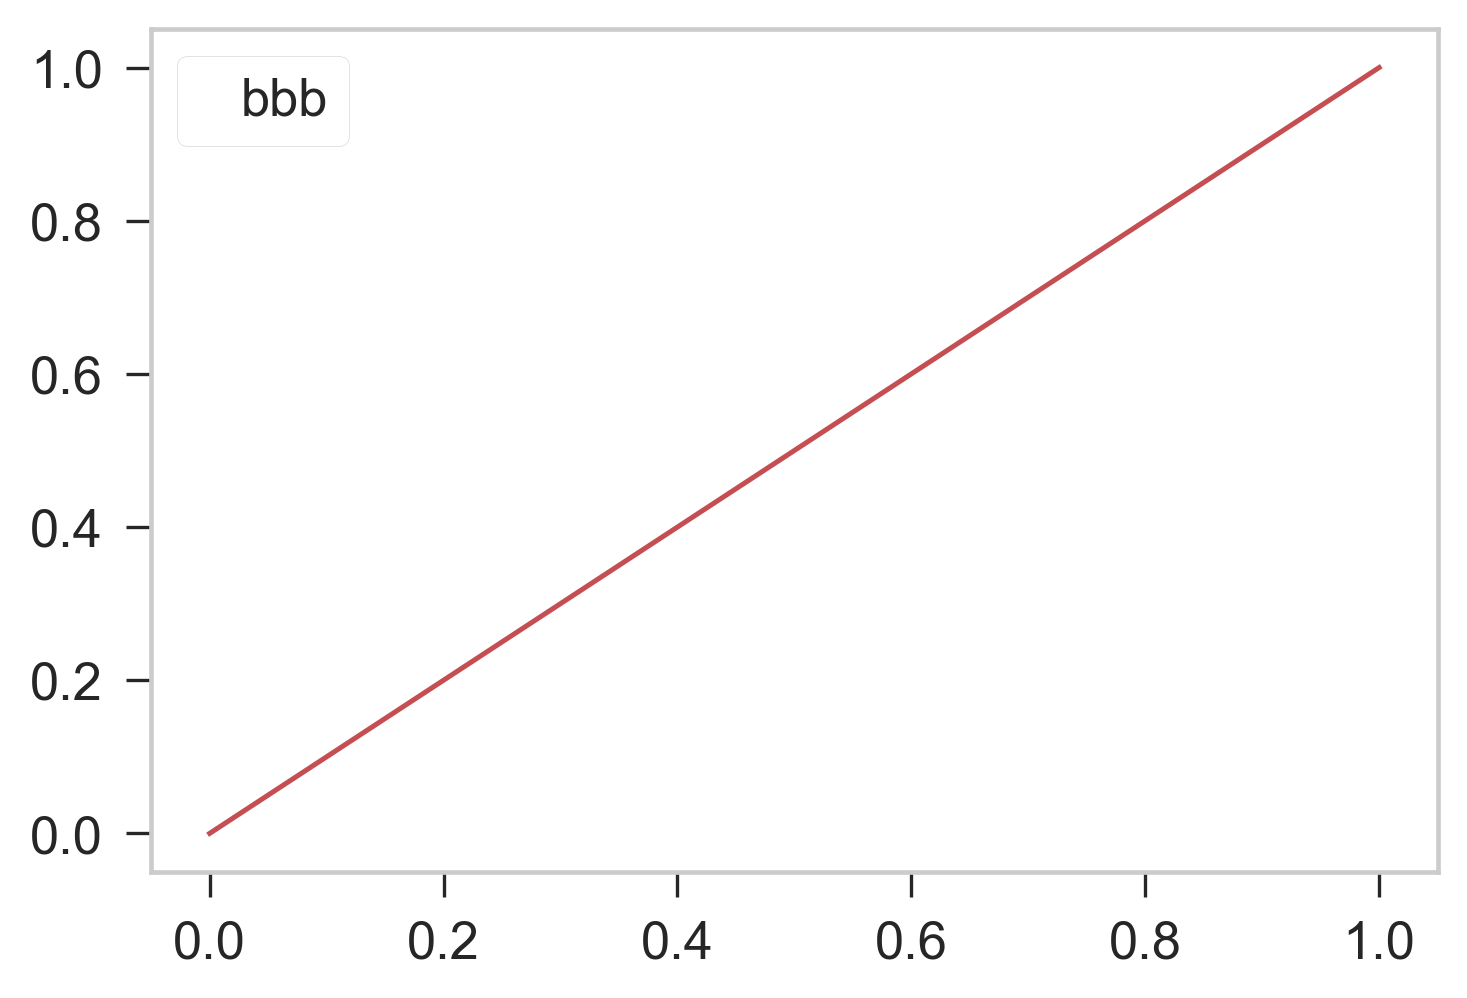

In [258]:
plt.plot([0,1],[0,1], 'r-')

plt.plot([], [], 'k', label = 'bbb')

plt.legend(handlelength = 0)
plt.show()